# Assignment 2: Identifying Unreported Cases of COVID-19

This assignment was adapted from [this paper](https://arxiv.org/abs/2006.02127), titled _Data-driven Identification of Number of Unreported Cases for COVID-19: Bounds and Limitations_. Feel free to read the paper if you like, but you will not need to know anything in the paper that is not explained here.

In [312]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt


## Goal

The goal of this assignment is to come up with a reasonable, data-driven estimate of how many people have COVID-19. You will have access to the data with the number of _reported_ cases. But the reported numbers are, of course, under-estimates because there are people who go unreported.

It seems reasonable to assume that the number of people who have it is proportional to the number reported. 

$$
\text{Number infected} = k \times \text{Number Reported}, \qquad k > 1
$$

Therefore, we just need to determine how many infected people a single case represents.

## Model

Recall that epidemiological models can have compartments representing groups of people with transition rates or probabilities between the compartments. In this assignment, we will have an _S_ (susceptible), an _I_ (infected), and an _R_ (reported) compartment. There's also a compartment for immune / isolated people who are, naturally, not connected to any other compartment. Let's call the total number of people in the population $N$.

|Variable|Meaning|
|--------|-------|
|$S_t$|No. susceptible people at time $t$|
|$I_t$|No. infected people at time $t$|
|$R_t$|No. reported people at time $t$|
|$N$|Total people in population|

|Transition|Associated Rate|
|----------|:---------------:|
|$S \to I$|Infection rate $\beta$|
|$I \to R$|Reporting probability $\gamma$|


At some time that we'll call $t$, the number of infected people $I_t$ changes over time in the following way (this is just part of the model, so we will not justify it too much). We'll measure $t$ with days, so $t-7$ is the value a week before $t$.

$$
\Delta I_t = \frac{S_t}{N}\beta \left( I_{t} - I_{t-7} \right).
$$

But we won't have access to the number infected people, so we need to rewrite this to be only in terms of reported numbers. I will wave my mathematical wand and tell you that

\begin{equation}
\Delta R_t = \left(1 - \frac{R_t}{\gamma(1-\rho)N} \right)\beta \left( R_{t} - R_{t-7} \right). \tag{1}
\end{equation}

In the equation above, $\rho$ is the percent of people who are immune / isolated from COVID and therefore play no part in its spread. We have no information about who is immune or isolated, so the best we can do is absorb the constant and learn $\bar\gamma = \gamma(1-\rho)$ from the data. Observe that this makes the empirical value we find always an underestimate: $\bar\gamma \leq \gamma$.

A derivation is included in section 3.1 of the paper if you're curious.

## Theory into practice

Now it's your turn to start implementing these ideas! There are only a few big steps:

1. Write code to do the computations according to the model equations.
3. Use the case reports to find the parameters that best describe the data.
4. Visualize / interpret our results.

In [313]:
def model(xt, rt, beta, gamma, N):
    """
    Xt: an array of values [ Rt - R(t-7) ] for every time t
    Rt: the number of reported cases at time t
    beta: infection rate
    gamma: reporting rate
    
    Return Delta Rt given data and parameters to model. 
    Basically implement equation 1. 
    """
    ### YOUR CODE HERE
    # results = []
    # p = 0
    # for i in range(len(xt)):
    #     results.append((1- rt[i] / (gamma * (1 - p) * N) * beta * xt[i]))
    # return torch.tensor(results, dtype=torch.double, requires_grad=True)
    return (1-rt[:len(xt)] /(gamma*N) * beta * xt)

def diff_with_delay(x, J):
    """
    Returns the differences in x over a window of size J.
    x is an array representing data sampled at regular intervals.
    Therefore if J = 1, you would return [ x[1] - x[0], x[2] - x[1], ... ]
    And if J = 2, you would return [ x[2] - x[0], x[3] - x[1], ... ]
    """
    diffs = []
    for i in range(len(x)):
        if (i + J) < len(x):
            diffs.append(x[i + J] - x[i])
    return diffs

def least_squares_error(Xt, Rt, beta, gamma, N):
    preds       = model(Xt, Rt, beta, gamma, N)
    delta_Rt    = (Rt[1:] - Rt[:-1])[6:]
    ### YOUR CODE HERE
    # Take a look here https://pytorch.org/docs/stable/nn.html to find a suitable loss function.
    # We want a function that is the sum of the squares of difference between our predictions and the given values, perhaps multiplied by a constant.
    # You just need to make lossFn point to a variable in the torch package. Do not call the function here.
    lossFn = torch.nn.MSELoss
    
    loss = lossFn(reduction='sum')( preds, delta_Rt )
    return loss

In [314]:
# No need to touch this cell. We are providing this for you.
# Retrieved from https://stackoverflow.com/questions/40443020/matlabs-smooth-implementation-n-point-moving-average-in-numpy-python
def smooth(a,WSZ):
    # a: NumPy 1-D array containing the data to be smoothed
    # WSZ: smoothing window size needs, which must be odd number,
    # as in the original MATLAB implementation
    out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ    
    r = np.arange(1,WSZ-1,2)
    start = np.cumsum(a[:WSZ-1])[::2]/r
    stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
    return np.concatenate((  start , out0, stop  ))

We will now consider the cases in New York State. The code below loads the time series data and puts the New York cases in the `data` variable. $N$ is the population of New York.

In [315]:
df = pd.read_csv("./time_series_covid19_confirmed_US.csv")
data = df[ df['Province_State'] == "New York" ].sum() 

### YOUR CODE HERE
# What does N represent again? (We discussed this at the top of the notebook)
# Use the U.S. Census Bureau rather than the first number Google shows.
N = 19453561

# J is the window we will use. Leave as 7.
J = 7

In [316]:
# data.keys() contains a lot of fields from the reports. 
# Select a slice of data.keys() so that it starts on the date 2/25/20 and ends on the data 7/6/20.

### YOUR CODE HERE
start = 45
end = 177+1
# for i in range(len(data.keys())):
#     if data.keys()[i] == '7/6/20':
#         print(i)
date_keys = data.keys()[start:end]


In [317]:
# This cell just sets up variables useful later, but you don't need to do anything here.
total_time_interval = [1, len(date_keys)]
raw_total_cases = data[date_keys].to_numpy(dtype=np.float32)

print(data[date_keys])

Rt = smooth(data[start:end].to_numpy(dtype=np.float32), 7)

training_interval = [ total_time_interval[1] - len(Rt) , total_time_interval[1] -1 ]
model_interval = [training_interval[0] + 6, training_interval[1]]
Xt = diff_with_delay(Rt, J)

2/25/20         0
2/26/20         0
2/27/20         0
2/28/20         0
2/29/20         0
            ...  
7/2/20     394954
7/3/20     395872
7/4/20     396598
7/5/20     397131
7/6/20     397649
Length: 133, dtype: object


In [318]:
beta = torch.tensor(np.random.rand() * 10 , requires_grad=True)
gamma = torch.tensor(np.random.rand(),  requires_grad=True)

Rt = torch.tensor(Rt, dtype=torch.double)
Xt = torch.tensor(Xt, dtype=torch.double)

In [319]:
# This cell will iteratively adjust the model parameters to minimize model error.

# What two variables do we want to optimize over? Hint: what controls the future predictions?
### YOUR CODE HERE
params = [beta, gamma]

optimizer = torch.optim.Adam( params , lr=0.01 )

steps = 4000
for t in range(steps):
    loss = least_squares_error(Xt, Rt, beta, gamma, N)
    if t % 100 == 0:
        print("After {} steps, the model's error = {}".format(t, loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

After 0 steps, the model&#39;s error = 9227928283.914774
After 100 steps, the model&#39;s error = 3568968657.9204025
After 200 steps, the model&#39;s error = 3130573025.266335
After 300 steps, the model&#39;s error = 2896531263.44707
After 400 steps, the model&#39;s error = 2733819989.049005
After 500 steps, the model&#39;s error = 2603655579.6421747
After 600 steps, the model&#39;s error = 2488701109.6296263
After 700 steps, the model&#39;s error = 2378073170.9345427
After 800 steps, the model&#39;s error = 2261481543.5180793
After 900 steps, the model&#39;s error = 2123181880.4972382
After 1000 steps, the model&#39;s error = 1923385652.9345043
After 1100 steps, the model&#39;s error = 1453867548.6968055
After 1200 steps, the model&#39;s error = 1021695762.6919074
After 1300 steps, the model&#39;s error = 1021640966.5941035
After 1400 steps, the model&#39;s error = 1021640966.5886134
After 1500 steps, the model&#39;s error = 1021640966.588587
After 1600 steps, the model&#39;s error = 

In [320]:
print(beta, gamma)

tensor(-3.0316, requires_grad=True) tensor(0.2379, requires_grad=True)


&lt;Figure size 432x288 with 0 Axes&gt;

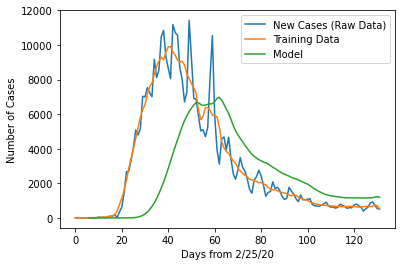

&lt;Figure size 432x288 with 0 Axes&gt;

In [321]:
plt.plot(np.diff(raw_total_cases), label = 'New Cases (Raw Data)')
plt.plot(np.arange(*training_interval), np.diff(Rt), label = 'Training Data')
preds = model(Xt, Rt, beta, gamma, N).detach().numpy()
plt.plot(np.arange(*model_interval), preds, label = 'Model')
plt.ylabel("Number of Cases")
plt.xlabel("Days from 2/25/20")
plt.legend()
plt.figure()

# Questions / Exercises

1. The plot above (hopefully) shows reasonable results from the model. How confident are you in the predictions that this model will make? How would you convince someone that this model's predictions are good? (What conclusion did we make about comparing models during Lecture 2?)
2. What steps would you take to train a model and make a plot for the cases in Berkeley? Go ahead and try that. It should only require a few changes to this notebook.
3. What assumption are we making about the values of $\beta$ and $\gamma$ over time?

Put your answers in a markdown cell below.

This week's paper is [Training Classifiers with Natural Language Explanations](https://arxiv.org/pdf/1805.03818.pdf). Give it a read and answer a few simple questions in the form.

1. The prediction looks good for me since its trend is in sync with the raw data. However, it seems to be an underestimation of the actual numbers. I would show my model to that person and explain to that person what compartments I included in my model and what data I used to train my model.
2. I will have to obtain the same data samples for Berkeley as I did for NY, preparing the training data, and use the same model to train. 
3. I think we are assuming the values of $\beta$ and $\gamma$ over time to be consistent